In [1]:
import pandas as pd
import numpy as np
import os
import torch

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model
from gene_variation_effects.modeling.utils import calculate_precision_from_conf_matrix, calculate_specificity_from_conf_matrix, calculate_recall_from_conf_matrix, generate_confusion_matrix, get_matrix_labels, generate_roc_curve, plot_roc_curve, show_confusion_matrix_heatmap

NEGATIVE_TRUTH, POSITIVE_TRUTH, NEGATIVE_PREDICTION, POSITIVE_PREDICTION = get_matrix_labels()

seed = 42

DATASET_NAME = 'dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))
target_array = df[TARGET_FEATURE]

df.drop(columns=[TARGET_FEATURE], inplace=True)
# df.drop(columns=['Type', 'GeneSymbol', 'VariantLength', 'VariantLengthDifference'], inplace=True)

ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = ['GeneSymbol']
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference', "OriginGermline"]

pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

2025-11-13 09:51:09.167 | INFO     | gene_variation_effects.config:<module>:11 - PROJ_ROOT path is: /Users/jeffbrin/Desktop/gene-variation-effects-ml


In [2]:
# Split the data
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1
GROUP_COLUMN = 'group'

training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

training_data, columns = pipeline.split_multi_features_from_data_output(training_data, df.columns, GROUP_COLUMN)
validation_data, _ = pipeline.split_multi_features_from_data_output(validation_data, df.columns, GROUP_COLUMN)
test_data, _ = pipeline.split_multi_features_from_data_output(test_data, df.columns, GROUP_COLUMN)


In [3]:
# Fit pipeline and transform data
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)

# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]

transformed_X_training, unique_gene_lists_training = pipeline.combine_duplicated_genesymbol_rows(transformed_X_training, embedding_features_indices[0], GROUP_COLUMN)
transformed_X_validation, unique_gene_lists_validation = pipeline.combine_duplicated_genesymbol_rows(feature_processor.transform(validation_data).astype(float), embedding_features_indices[0], GROUP_COLUMN)
transformed_X_test, unique_gene_lists_testing = pipeline.combine_duplicated_genesymbol_rows(feature_processor.transform(test_data).astype(float), embedding_features_indices[0], GROUP_COLUMN)

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [4]:
embedding_input_sizes = pipeline.get_embedding_input_sizes(feature_processor)

In [5]:
# We only have one embedding input size right now, since we're doing this by hand anyways we can probably hard-code each one
# going forward. Maybe there is a way to automate this.
HIDDEN_SIZES = [256, 128, 64]
DROPOUT = 0
if len(embedding_input_sizes) > 0:
    GENE_LABELS_EMBEDDING_SIZE = int(embedding_input_sizes[0] ** 0.5)
    embedding_dimension_mapping = np.array([[embedding_input_sizes[0], GENE_LABELS_EMBEDDING_SIZE]])
else:
    embedding_dimension_mapping = np.array([])


2025-11-13 09:52:03.974 | INFO     | gene_variation_effects.modeling.train:run_training_loop:134 - Epoch 1 validation F Score=0.6246
2025-11-13 09:52:03.985 | INFO     | gene_variation_effects.modeling.train:run_training_loop:135 - Epoch 1: accuracy=0.4757
2025-11-13 09:52:03.985 | INFO     | gene_variation_effects.modeling.train:run_training_loop:136 - Epoch 1: validation accuracy=0.4854
2025-11-13 09:52:03.986 | INFO     | gene_variation_effects.modeling.train:run_training_loop:137 - Epoch 1: validation loss=0.6918
2025-11-13 09:52:04.081 | INFO     | gene_variation_effects.modeling.train:run_training_loop:134 - Epoch 2 validation F Score=0.6312
2025-11-13 09:52:04.082 | INFO     | gene_variation_effects.modeling.train:run_training_loop:135 - Epoch 2: accuracy=0.5146
2025-11-13 09:52:04.082 | INFO     | gene_variation_effects.modeling.train:run_training_loop:136 - Epoch 2: validation accuracy=0.4669
2025-11-13 09:52:04.082 | INFO     | gene_variation_effects.modeling.train:run_traini

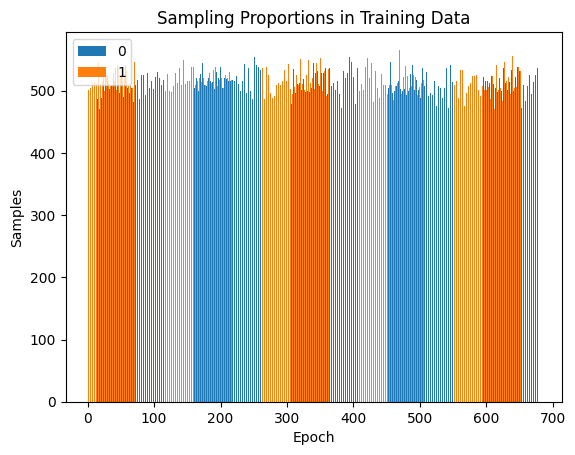

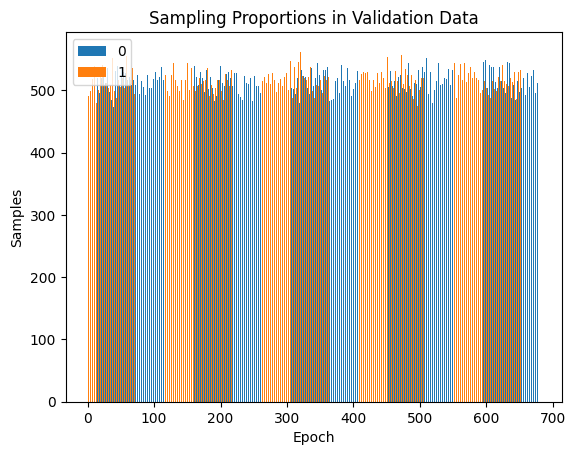

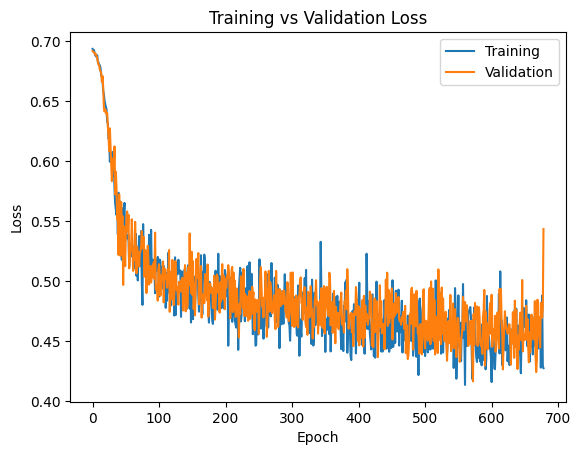

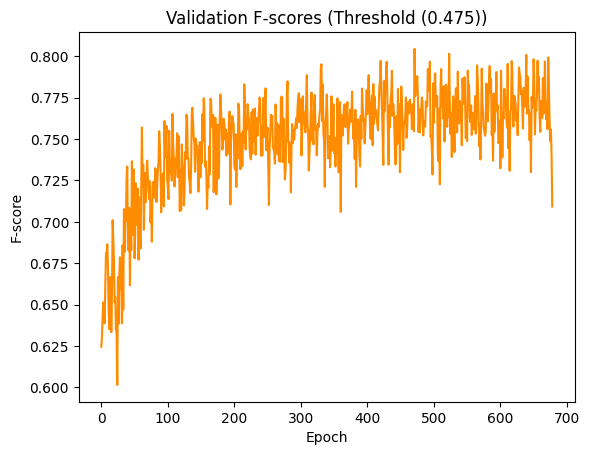

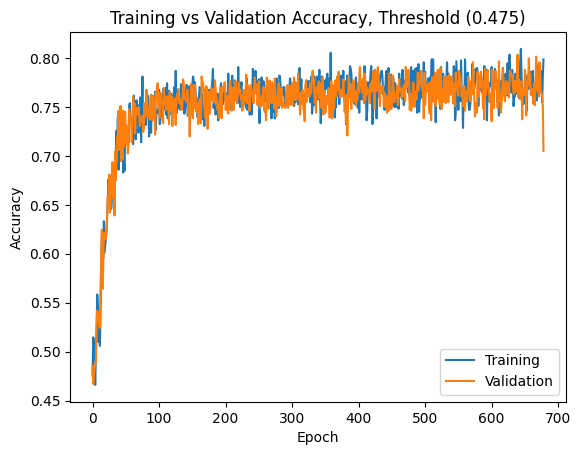

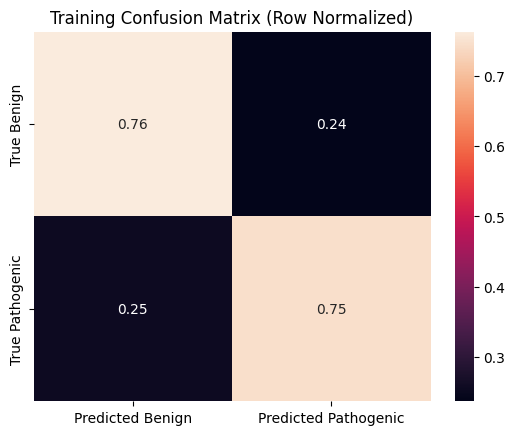

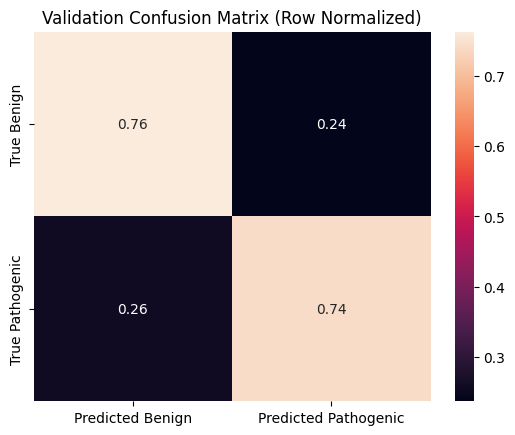

<Figure size 640x480 with 0 Axes>

In [6]:
from gene_variation_effects.modeling.utils import logits_to_prediction

# Subtracting 1 from shape since shape here includes the tag used to join gene symbols
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

BATCH_SIZE = 1028
PATIENCE = float('inf')
POSITIVE_THRESHOLD = 0.475

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimal_model_dict, training_prediction_logits, val_prediction_logits, \
    dataloader_training_targets, dataloader_val_targets = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, 
    validation_target_array, unique_gene_lists_training, unique_gene_lists_validation, embedding_features_indices, patience=PATIENCE, positive_threshold=POSITIVE_THRESHOLD,
    positive_class_loss_weight=torch.Tensor([1]),
    optimizer=optimizer, visualize=True)
torch.save(optimal_model_dict, "../models/model.pth")


all_training_predictions = logits_to_prediction(torch.Tensor(training_prediction_logits), POSITIVE_THRESHOLD)
all_val_predictions = logits_to_prediction(torch.Tensor(val_prediction_logits), POSITIVE_THRESHOLD)

training_confusion_matrix_df = generate_confusion_matrix(all_training_predictions, dataloader_training_targets, normalize="true")
val_confusion_matrix_df = generate_confusion_matrix(all_val_predictions, dataloader_val_targets, normalize="true")

show_confusion_matrix_heatmap(training_confusion_matrix_df, "Training")
show_confusion_matrix_heatmap(val_confusion_matrix_df, "Validation")

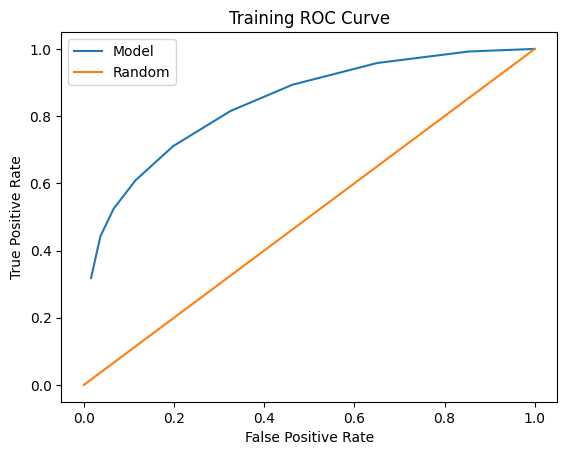

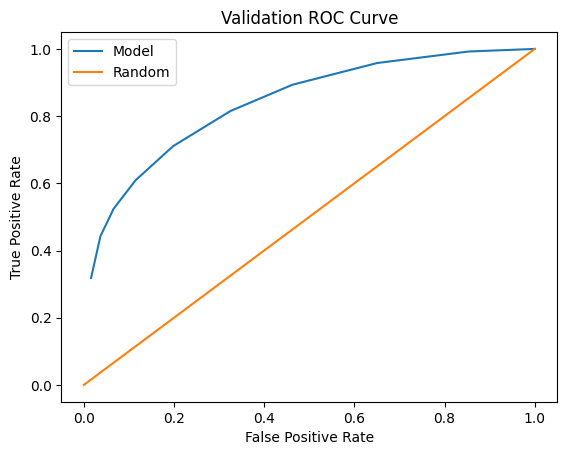

In [7]:
training_roc_curve = generate_roc_curve(training_prediction_logits, dataloader_training_targets)
plot_roc_curve(training_roc_curve, "Training", show_random=True)
val_roc_curve = generate_roc_curve(val_prediction_logits, dataloader_val_targets)
plot_roc_curve(training_roc_curve, "Validation", show_random=True)    

In [8]:
precision = calculate_precision_from_conf_matrix(val_confusion_matrix_df)
recall = calculate_recall_from_conf_matrix(val_confusion_matrix_df)
specificity = calculate_specificity_from_conf_matrix(val_confusion_matrix_df)

print(precision)
print(recall)
print(specificity)

0.7578999440162488
0.7414762050931916
0.7631462672863947


In [9]:
# Recreate the model structure
model.load_state_dict(torch.load("../models/model.pth"))

<All keys matched successfully>

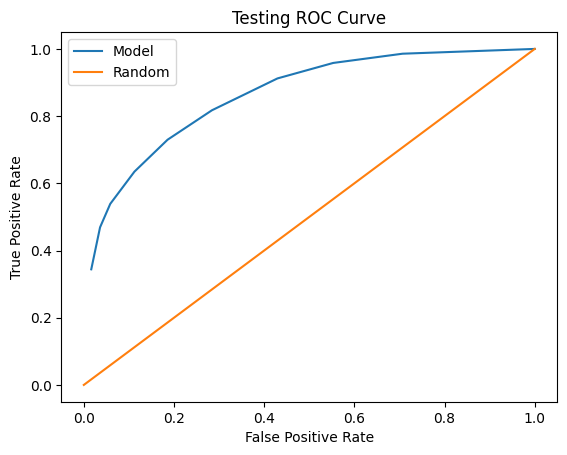

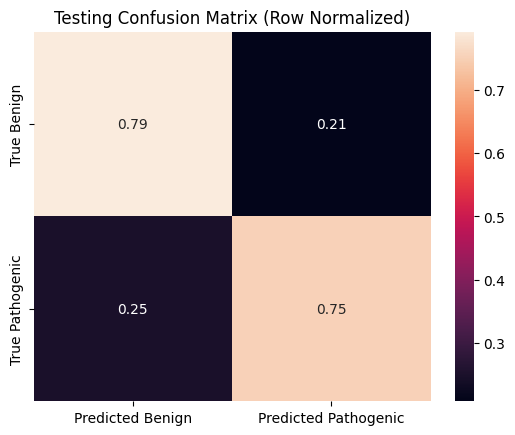

Avg Loss 0.45375719762200023
Accuracy tensor(0.7719)
F Score 0.7621199236086691


<Figure size 640x480 with 0 Axes>

In [10]:
avg_loss, accuracy, predictions, targets, f_score = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices, unique_gene_lists_testing)

roc_curve = generate_roc_curve(predictions, targets)
plot_roc_curve(roc_curve, "Testing", show_random=True)

all_test_predictions = logits_to_prediction(torch.Tensor(predictions), POSITIVE_THRESHOLD)
test_confusion_matrix_df = generate_confusion_matrix(all_test_predictions, targets, normalize="true")
# plt.matshow(training_confusion_matrix_df)
# plt.matshow(val_confusion_matrix_df)
show_confusion_matrix_heatmap(test_confusion_matrix_df, "Testing")

print("Avg Loss", avg_loss)
print("Accuracy", accuracy)
print("F Score", f_score)